<a href="https://colab.research.google.com/github/milanfx/DTSA-5511/blob/main/GAN_Monet_Style_Transfer_Kaggle_Mini_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div style="font-family:Roboto Condensed SemiBold; font-size:150%; letter-spacing: 0px; background-color:SteelBlue; color:#f8f2e4; text-align:center; padding-top:10px; padding-bottom:10px; border: 5px solid #f8f2e4; border-radius: 20px;"><h1><b>
GAN Monet Style Transfer Kaggle Mini-Project
</b></h1></div>

---

<div style="text-align:center">
<img src="https://github.com/milanfx/Dataset/blob/main/images/GAN%20logo.png?raw=true" style="width:850px; height:200px;">
</div>


<div style="font-family:Roboto Condensed SemiBold; font-size:120%; letter-spacing: 0px; background-color:#f8f2e4; color:SteelBlue; text-align:center; padding-top:0px; padding-bottom:0px; border: 3px solid SteelBlue; border-radius: 20px;">

## **1. Project Introduction**

</div>

---

### **1.1 Project understanding**

**Background:**

- This Kaggle competition aims to advance the field of computer vision by utilizing generative adversarial networks (GANs) to replicate the unique art style of Claude Monet in digital photos.

- Style transfer technology allows us to transform ordinary photos into masterpieces that mimic the color choices and brush strokes of famous artists like Monet.

**Objective:**

- This project utilizes classic GAN architecture to generate images in the style of Claude Monet.

- The goal is to develop a model that can transform around 7000 original photos into Monet-style artworks.

- Construct an independent CycleGAN model based on the Monet CycleGAN Tutorial.

**Chanllenge:**

- Assessing the artistic effect of the images is subjective and challenging to evaluate through visual inspection alone.

- The computational complexity of the GAN model requires balancing the time needed for training and the quality of the generated images to ensure efficient and reliable performance.

---

### **1.2 Data Understanding**

**Data Description**

- The dataset contains four files: monet_tfrec, photo_tfrec, monet_jpg, and photo_jpg.

  - monet_jpg: Contains 300 Monet paintings in JPEG format, each sized 256x256 pixels.

  - monet_tfrec: Contains the same 300 Monet paintings in TFRecord format.

  - photo_jpg: Contains 7028 photos in JPEG format, each sized 256x256 pixels.

  - photo_tfrec: Contains the same 7028 photos in TFRecord format.

- The TFRecord files will be used for training our model to learn and apply the Monet style to photos.

- The JPEG files will be used for visualizing the training results and for generating and submitting the final Monet-style images.

**Evaluation Method**

- The model will be evaluated on **MiFID** (Memorization-informed Frechet Inception Distance).

- **FID** measures how similar the generated images are to the real images:

$$\text{FID} = \|\mu_r - \mu_g\|^2 + \text{Tr}(\Sigma_r + \Sigma_g - 2(\Sigma_r \Sigma_g)^{1/2})$$

- **Memorization Distance** measures the minimum cosine distance between the features of the generated images and all training images, averaged across all generated images.

$$d_{ij} = 1 - \cos(f_{gi}, f_{rj}) = 1 - \frac{f_{gi} \cdot f_{rj}}{|f_{gi}| |f_{rj}|}$$

$$d = \frac{1}{N} \sum_{i} \min_{j} d_{ij}$$

- **MiFID** combines FID with memorization distance to evaluate the quality and originality of the generated images.

$$\text{MiFID} = \text{FID} \cdot \frac{1}{d_{\text{thr}}}$$

- A lower MiFID indicates that the generated images are of high quality and not too similar to the training images, ensuring both realism and originality. This balance is crucial for generating images that are convincing yet diverse, avoiding overfitting to the training data.

---

### **1.3 Data Loading**

**Load Library:**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
import warnings
import shutil
import PIL
from glob import glob

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, initializers, Model
from tensorflow.keras.callbacks import ModelCheckpoint

random.seed(1)
np.random.seed(1)
tf.random.set_seed(1)

warnings.filterwarnings('ignore')
%matplotlib inline

**Load Data from Kaggle:**

In [2]:
from google.colab import userdata

os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

In [3]:
!kaggle competitions download -c gan-getting-started
!unzip -q gan-getting-started.zip -d dataset

100% 366M/367M [00:16<00:00, 23.3MB/s]
100% 367M/367M [00:16<00:00, 22.7MB/s]


**Check Data Size:**

In [4]:
monet_tfrec_path = '/content/dataset/monet_tfrec'
photo_tfrec_path = '/content/dataset/photo_tfrec'

MONET_FILENAMES = glob(os.path.join(monet_tfrec_path, '*.tfrec'))
PHOTO_FILENAMES = glob(os.path.join(photo_tfrec_path, '*.tfrec'))

print(f'Number of Monet TFRecord files: {len(MONET_FILENAMES)}')
print(f'Number of Photo TFRecord files: {len(PHOTO_FILENAMES)}')

Number of Monet TFRecord files: 5
Number of Photo TFRecord files: 20


In [5]:
monet_jpg_path = '/content/dataset/monet_jpg'
photo_jpg_path = '/content/dataset/photo_jpg'

MONET_JPG = glob(os.path.join(monet_jpg_path, '*.jpg'))
PHOTO_JPG = glob(os.path.join(photo_jpg_path, '*.jpg'))

print(f'Number of Monet images: {len(MONET_JPG)}')
print(f'Number of Photo images: {len(PHOTO_JPG)}')

Number of Monet images: 300
Number of Photo images: 7038


- The image files have been loaded for further preprocessing and analysis.

---

<div style="font-family:Roboto Condensed SemiBold; font-size:120%; letter-spacing: 0px; background-color:#f8f2e4; color:SteelBlue; text-align:center; padding-top:0px; padding-bottom:0px; border: 3px solid SteelBlue; border-radius: 20px;">

## **2. Exploratory Analysis**

</div>

---

### **2.1 MONET Samples**

**Preview 15 MONET Images:**

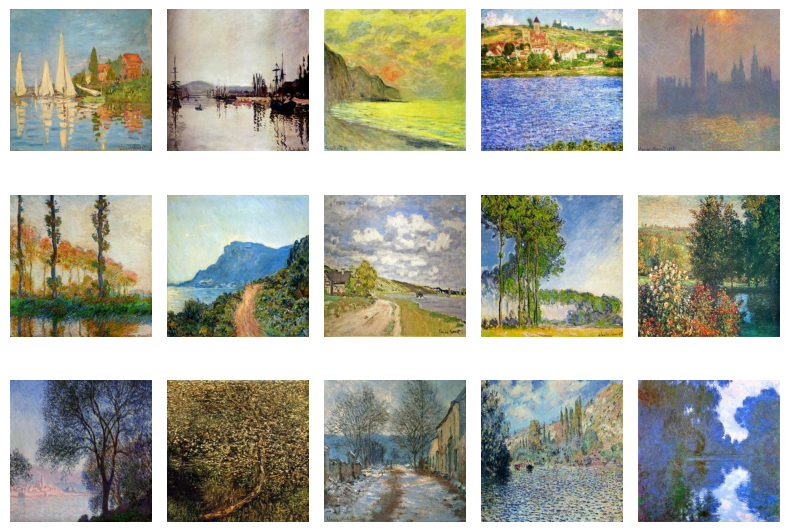

In [6]:
fig, axes = plt.subplots(3, 5, figsize=(8, 6))

for count, (ax, file_name) in enumerate(zip(axes.flatten(), MONET_JPG[:15]), 1):
    img = PIL.Image.open(file_name)
    ax.imshow(np.array(img))
    ax.axis('off')

plt.tight_layout()
plt.show()

- Monet's painting style is characterized by soft, diffused light and vibrant, pastel colors, creating an impressionistic and dreamy quality.

---

### **2.2 PHOTO Samples**

**Preview 15 PHOTO Images:**

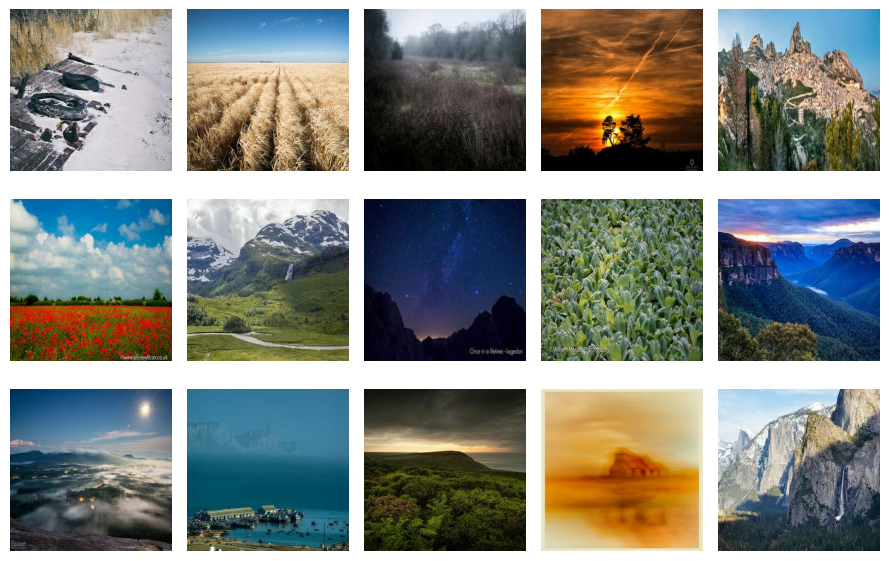

In [7]:
fig, axes = plt.subplots(3, 5, figsize=(9, 6))

for count, (ax, file_name) in enumerate(zip(axes.flatten(), PHOTO_JPG[:15]), 1):
    img = PIL.Image.open(file_name)
    ax.imshow(np.array(img))
    ax.axis('off')

plt.tight_layout()
plt.show()

- In contrast, real photos typically feature sharp details, accurate colors, and clear, well-defined edges, capturing the scene with realism and precision.

---

### **2.3 Image Proprecessing**

**Define the decode_image function:**

- This function decodes JPEG images, scales the pixel values to the range [-1, 1], and reshapes them to 256x256 pixels.

**Define the read_tfrecord function:**

- This function parses a TFRecord file, extracts the image data, and uses decode_image to decode the image.

**Load and batch the dataset:**

- We use the load_dataset function to load datasets from TFRecord files, map them to read_tfrecord for decoding, and batch the data with a batch size of 1 for training.

In [8]:
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [256, 256, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord)
    return dataset

monet_ds = load_dataset(MONET_FILENAMES, labeled=True).batch(1)
photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True).batch(1)

In [9]:
for image in monet_ds.take(1):
    print(f"Image shape: {image.shape}, dtype: {image.dtype}")

Image shape: (1, 256, 256, 3), dtype: <dtype: 'float32'>


- We loaded the Monet paintings and original photos into two datasets, monet_ds and photo_ds, for further analysis.

---

<div style="font-family:Roboto Condensed SemiBold; font-size:120%; letter-spacing: 0px; background-color:#f8f2e4; color:SteelBlue; text-align:center; padding-top:0px; padding-bottom:0px; border: 3px solid SteelBlue; border-radius: 20px;">

## **3. Model Architecture**

</div>

---

### **3.1 CycleGAN Structure**

A CycleGAN is a type of Generative Adversarial Network (GAN) that performs image-to-image translation without requiring paired examples.

We built a CycleGAN which involves the following steps:

- **Downsample**: Reduces the spatial dimensions of the image while increasing the number of channels.

- **Upsample**: Increases the spatial dimensions of the image, restoring it to the original size.

- **Generator**: Transforms images from one domain to another (e.g., photos to Monet paintings).

- **Discriminator**: Differentiates between real images and generated images, helping the Generator improve the quality of the generated images.

- **Loss Function**: Uses various conditions to drive the model towards generating realistic and accurate images.

---

### **3.2 Downsample and Upsample**

**Downsample:**

- Takes the input image and applies convolution to reduce spatial dimensions while increasing channels.

- Optionally normalizes the image using instance normalization.

- Outputs the image with reduced size and activated features using LeakyReLU.

In [10]:
def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                kernel_initializer=initializer, use_bias=False))
    if apply_instancenorm:
        result.add(layers.LayerNormalization(gamma_initializer=gamma_init))
    result.add(layers.LeakyReLU())
    return result

**Upsample:**

- Takes the input image and applies transposed convolution to increase spatial dimensions while decreasing channels.

- Normalizes the image using instance normalization and optionally applies dropout.

- Outputs the image with increased size and activated features using ReLU.

In [11]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2, padding='same',
                     kernel_initializer=initializer, use_bias=False))

    result.add(layers.LayerNormalization(gamma_initializer=gamma_init))
    if apply_dropout:
        result.add(layers.Dropout(0.5))
    result.add(layers.ReLU())
    return result

- Together, these steps enable the model to learn and apply intricate transformations, allowing the CycleGAN to effectively translate images between different styles or domains.

---

### **3.3 Generator and Discriminator**

**Generator:**

- Takes the input image and applies a series of downsampling layers to reduce spatial dimensions and increase channels.

- Uses skip connections to store intermediate outputs from downsampling for later use in upsampling.

- Applies a series of upsampling layers, combining upsampled features with corresponding downsampled features to restore the image's original size and detail.

- Outputs the final image with a transposed convolution layer and tanh activation, resulting in an image of the same size as the input but transformed according to the learned style.

In [12]:
def Generator():
    inputs = layers.Input(shape=[256,256,3])

    down_stack = [
        downsample(64, 4, apply_instancenorm=False), # (bs, 128, 128, 64)
        downsample(128, 4), # (bs, 64, 64, 128)
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
        downsample(512, 4), # (bs, 2, 2, 512)
        downsample(512, 4), # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4), # (bs, 16, 16, 1024)
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(128, 4), # (bs, 64, 64, 256)
        upsample(64, 4), # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(3, 4, strides=2, padding='same',
                    kernel_initializer=initializer, activation='tanh') # (bs, 256, 256, 3)
    x = inputs
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    skips = reversed(skips[:-1])

    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])
    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

**Discriminator:**

- Takes the input image and applies a series of downsampling layers to reduce spatial dimensions and increase channels.

- Adds zero padding and convolution layers to further process the downsampled image, followed by normalization and activation.

- Outputs a single-channel image with a final convolution layer, indicating the probability that each pixel belongs to a real or fake image.

In [13]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
    inp = layers.Input(shape=[256, 256, 3], name='input_image')
    x = inp

    down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

    zero_pad1 = layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = layers.Conv2D(512, 4, strides=1,
                kernel_initializer=initializer, use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    norm1 = keras.layers.GroupNormalization(gamma_initializer=gamma_init, groups=-1)(conv)
    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)
    last = layers.Conv2D(1, 4, strides=1,
                kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

    return keras.Model(inputs=inp, outputs=last)

In [14]:
monet_generator = Generator()
photo_generator = Generator()

monet_discriminator = Discriminator()
photo_discriminator = Discriminator()

- Together, these components allow the CycleGAN to generate realistic images and distinguish between real and generated images, ensuring high-quality and believable image translations between different styles or domains.

---

### **3.4 Cycle GAN and Loss Function**

**Build Cycle GAN:**

- Initializes the generators and discriminators for both domains.

- Configures optimizers and loss functions.

- Transforms images between domains and back to ensure consistency.

- Calculates losses for generators and discriminators.

- Applies gradients to update and optimize the model.

In [15]:
class CycleGan(keras.Model):
    def __init__(self, monet_generator, photo_generator, monet_discriminator, photo_discriminator, lambda_cycle=10):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle

    def compile(self, m_gen_optimizer, p_gen_optimizer, m_disc_optimizer, p_disc_optimizer, gen_loss_fn, disc_loss_fn, cycle_loss_fn, identity_loss_fn):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn

    @tf.function
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data

        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputting real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputting fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss, self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss, self.p_gen.trainable_variables)
        monet_discriminator_gradients = tape.gradient(monet_disc_loss, self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss, self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients, self.m_gen.trainable_variables))
        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients, self.p_gen.trainable_variables))
        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients, self.m_disc.trainable_variables))
        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients, self.p_disc.trainable_variables))

        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

**Loss Function:**

- **discriminator_loss**: Measures the ability to distinguish between real and fake images using binary cross-entropy.

- **generator_loss**: Evaluates how well the generator creates realistic images using binary cross-entropy.

- **cycle_consistency_loss**: Ensures the generated image can be transformed back to the original with minimal loss using scaled mean absolute error.

- **identity_loss**: Ensures images already in the target domain remain unchanged using scaled mean absolute error.

In [16]:
def discriminator_loss(real, generated):
    real_loss = keras.losses.BinaryCrossentropy(
        from_logits=True, reduction=keras.losses.Reduction.NONE
    )(tf.ones_like(real), real)

    generated_loss = keras.losses.BinaryCrossentropy(
        from_logits=True, reduction=keras.losses.Reduction.NONE
    )(tf.zeros_like(generated), generated)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss * 0.5

def generator_loss(generated):
    return keras.losses.BinaryCrossentropy(
        from_logits=True, reduction=keras.losses.Reduction.NONE
    )(tf.ones_like(generated), generated)

def cycle_consistency_loss(real_image, cycled_image, LAMBDA):
    loss = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return LAMBDA * loss

def identity_loss(real_image, same_image, LAMBDA):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss

---

### **3.5 Model Training**

**Merging Components:**

In [17]:
monet_generator_optimizer = keras.optimizers.Adam(0.002, beta_1=0.5)
photo_generator_optimizer = keras.optimizers.Adam(0.002, beta_1=0.5)

monet_discriminator_optimizer = keras.optimizers.Adam(0.002, beta_1=0.5)
photo_discriminator_optimizer = keras.optimizers.Adam(0.002, beta_1=0.5)

cycle_gan_model = CycleGan(
    monet_generator,
    photo_generator,
    monet_discriminator,
    photo_discriminator
)

cycle_gan_model.compile(
    m_gen_optimizer = monet_generator_optimizer,
    p_gen_optimizer = photo_generator_optimizer,
    m_disc_optimizer = monet_discriminator_optimizer,
    p_disc_optimizer = photo_discriminator_optimizer,
    gen_loss_fn = generator_loss,
    disc_loss_fn = discriminator_loss,
    cycle_loss_fn = cycle_consistency_loss,
    identity_loss_fn = identity_loss
)

**Training the Model:**

In [18]:
history = cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=30
)

Epoch 1/30
300/300 [==============================] - 93s 166ms/step - monet_gen_loss: 3.8732 - photo_gen_loss: 3.9525 - monet_disc_loss: 0.6647 - photo_disc_loss: 0.6710
Epoch 2/30
300/300 [==============================] - 51s 169ms/step - monet_gen_loss: 3.0711 - photo_gen_loss: 3.1534 - monet_disc_loss: 0.6424 - photo_disc_loss: 0.6402
Epoch 3/30
300/300 [==============================] - 51s 171ms/step - monet_gen_loss: 2.8400 - photo_gen_loss: 2.8794 - monet_disc_loss: 0.6303 - photo_disc_loss: 0.6383
Epoch 4/30
300/300 [==============================] - 51s 170ms/step - monet_gen_loss: 2.7314 - photo_gen_loss: 2.7376 - monet_disc_loss: 0.6203 - photo_disc_loss: 0.6337
Epoch 5/30
300/300 [==============================] - 51s 170ms/step - monet_gen_loss: 2.7487 - photo_gen_loss: 2.6836 - monet_disc_loss: 0.6032 - photo_disc_loss: 0.6250
Epoch 6/30
300/300 [==============================] - 51s 169ms/step - monet_gen_loss: 2.7358 - photo_gen_loss: 2.6373 - monet_disc_loss: 0.5921 

- Monet_gen_loss and Photo_gen_loss represent the generator losses for Monet and photo images respectively.

- Monet_disc_loss and Photo_disc_loss represent the discriminator losses for Monet and photo images respectively.

- Together, they indicate the model's ability to generate realistic images and correctly distinguish between real and generated images.

<div style="font-family:Roboto Condensed SemiBold; font-size:120%; letter-spacing: 0px; background-color:#f8f2e4; color:SteelBlue; text-align:center; padding-top:0px; padding-bottom:0px; border: 3px solid SteelBlue; border-radius: 20px;">

## **4. Results and Analysis**

</div>

---

### **4.1 Fitted Images Visualization**

**Fit to the Original Images:**

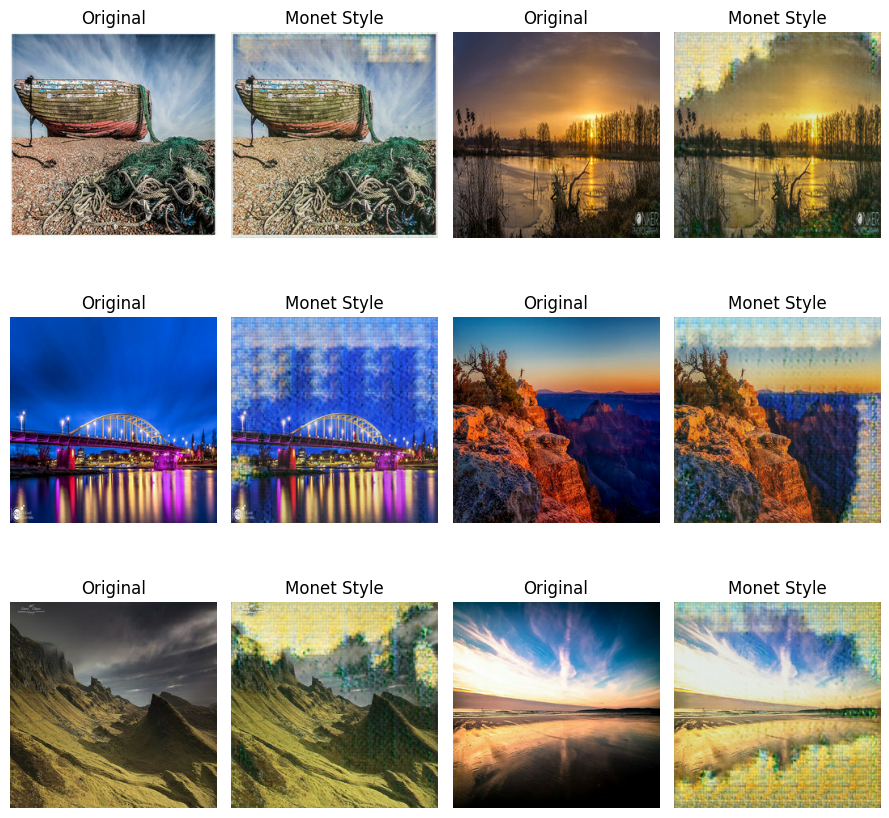

In [27]:
_, ax = plt.subplots(3, 4, figsize=(9, 9))

for i, img_batch in enumerate(photo_ds.take(6)):
    img = img_batch[0]
    prediction = monet_generator(img_batch, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)

    img = (img * 127.5 + 127.5).numpy().astype(np.uint8)
    ax[i//2, 2*(i%2)].imshow(img)
    ax[i//2, 2*(i%2) + 1].imshow(prediction)
    ax[i//2, 2*(i%2)].set_title("Original")
    ax[i//2, 2*(i%2) + 1].set_title("Monet Style")
    ax[i//2, 2*(i%2)].axis("off")
    ax[i//2, 2*(i%2) + 1].axis("off")
plt.tight_layout()
plt.show()

- Through model iterations, the background of the original images has noticeably incorporated the Monet style, while the main subjects have remained largely unchanged to the naked eye.

- Ideally, we want the entire image to adopt the Monet style, but the model has differentiated between the subject and the background in its processing.

- Hence, this model's fitting performance is not satisfactory.


---

### **4.2 Prediction Accuracy**

In [ ]:
output_dir = "/content/working/images" # Change to Kaggle when Submit
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

i = 1
for img_batch in photo_ds:
    prediction = monet_generator(img_batch, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save(os.path.join(output_dir, f"{i}.jpg"))
    i += 1

shutil.make_archive("/content/working/images_zip", 'zip', output_dir) # Change to Kaggle when Submit

<div style="text-align:center">
<img src="https://github.com/milanfx/Dataset/blob/main/images/GAN%20Score.png?raw=true" style="width:850px;">
</div>


- The private score is 54.6, which is acceptable for a beginner.

---

<div style="font-family:Roboto Condensed SemiBold; font-size:120%; letter-spacing: 0px; background-color:#f8f2e4; color:SteelBlue; text-align:center; padding-top:0px; padding-bottom:0px; border: 3px solid SteelBlue; border-radius: 20px;">

## **5. Project Conclusion**

</div>

---

### **5.1 Model Summary**

1. We successfully built a CycleGAN model based on the Kaggle Monet CycleGAN Tutorial.

2. The model effectively added Monet style elements, as reflected in the MiFID score.

3. In practice, the Monet style elements primarily covered the background rather than the objects themselves, indicating that the model's performance still has significant room for improvement.

---

### **5.2 Next Step**

**1. Optimize Hyperparameters**: This model primarily used hyperparameters from the Kaggle Monet CycleGAN Tutorial. We can further enhance model performance by optimizing these hyperparameters.

**2. Increase Dataset Size**: The number of Monet images used in this model is insufficient. We can improve the model's performance by acquiring more Monet images from external sources or by using augmentation techniques to enrich the existing dataset.

**3. Explore Different Architectures**: Experiment with different GAN architectures, such as using a more advanced GAN variant or modifying the existing CycleGAN architecture, to improve the model's ability to integrate Monet style elements more effectively.

---

**Reference**: Kaggle Monet CycleGAN Tutorial - https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial

---